# Natural Language Processing

### 2.2 Scaling word2vec and introduction to Neural Nets for NLP
<br><br>
Prof. Iacopo Masi and Prof. Stefano Faralli

In [4]:
import matplotlib.pyplot as plt
import scipy
import random
import numpy as np
import pandas as pd
pd.set_option('display.colheader_justify', 'center')

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
#plt.style.use('seaborn-whitegrid')

font = {'family' : 'Times',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)


# Aux functions

def plot_grid(Xs, Ys, axs=None):
    ''' Aux function to plot a grid'''
    t = np.arange(Xs.size) # define progression of int for indexing colormap
    if axs:
        axs.plot(0, 0, marker='*', color='r', linestyle='none') #plot origin
        axs.scatter(Xs,Ys, c=t, cmap='jet', marker='.') # scatter x vs y
        axs.axis('scaled') # axis scaled
    else:
        plt.plot(0, 0, marker='*', color='r', linestyle='none') #plot origin
        plt.scatter(Xs,Ys, c=t, cmap='jet', marker='.') # scatter x vs y
        plt.axis('scaled') # axis scaled
        
def linear_map(A, Xs, Ys):
    '''Map src points with A'''
    # [NxN,NxN] -> NxNx2 # add 3-rd axis, like adding another layer
    src = np.stack((Xs,Ys), axis=Xs.ndim)
    # flatten first two dimension
    # (NN)x2
    src_r = src.reshape(-1,src.shape[-1]) #ask reshape to keep last dimension and adjust the rest
    # 2x2 @ 2x(NN)
    dst = A @ src_r.T # 2xNN
    #(NN)x2 and then reshape as NxNx2
    dst = (dst.T).reshape(src.shape)
    # Access X and Y
    return dst[...,0], dst[...,1]


def plot_points(ax, Xs, Ys, col='red', unit=None, linestyle='solid'):
    '''Plots points'''
    ax.set_aspect('equal')
    ax.grid(True, which='both')
    ax.axhline(y=0, color='gray', linestyle="--")
    ax.axvline(x=0, color='gray',  linestyle="--")
    ax.plot(Xs, Ys, color=col)
    if unit is None:
        plotVectors(ax, [[0,1],[1,0]], ['gray']*2, alpha=1, linestyle=linestyle)
    else:
        plotVectors(ax, unit, [col]*2, alpha=1, linestyle=linestyle)

def plotVectors(ax, vecs, cols, alpha=1, linestyle='solid'):
    '''Plot set of vectors.'''
    for i in range(len(vecs)):
        x = np.concatenate([[0,0], vecs[i]])
        ax.quiver([x[0]],
                   [x[1]],
                   [x[2]],
                   [x[3]],
                   angles='xy', scale_units='xy', scale=1, color=cols[i],
                   alpha=alpha, linestyle=linestyle, linewidth=2)

## My own latex definitions

$$\def\mbf#1{\mathbf{#1}}$$
$$\def\bmf#1{\boldsymbol{#1}}$$
$$\def\bx{\mbf{x}}$$
$$\def\bxt#1{\mbf{x}_{\text{#1}}}$$
$$\def\bv{\mbf{v}}$$
$$\def\bz{\mbf{z}}$$
$$\def\bmu{\bmf{\mu}}$$
$$\def\bsigma{\bmf{\Sigma}}$$
$$\def\Rd#1{\in \mathbb{R}^{#1}}$$
$$\def\chain#1#2{\frac{\partial #1}{\partial #2}}$$
$$\def\loss{\mathcal{L}}$$
$$\def\params{\bmf{\theta}}$$


# Today's lecture
## - Skip-Gram and Continuous Bag of Words (CBOW)
## - How to scale word2vec
### - Negative Sampling
### - Hierarchical Softmax
## - Introduction to Neural Nets for NLP

# This lecture material is taken from
📘 **Chapter 6 Jurafsky Book**

📘 **Chapter 14.5 Eisenstein Book**
- [Stanford Slide Word2Vec](http://web.stanford.edu/class/cs224n/slides/cs224n-2022-lecture01-wordvecs2.pdf)
- [Stanford Lecture Word2Vec](https://www.youtube.com/watch?v=rmVRLeJRkl4&list=PLoROMvodv4rOSH4v6133s9LFPRHjEmbmJ&index=1)
- [Stanford Notes on Word2Vec](http://web.stanford.edu/class/cs224n/readings/cs224n-2019-notes01-wordvecs1.pdf)


📝 Research papers on word2vec and hierarchical softmax:
- [First paper: word2vec + hierarchical softmax](https://arxiv.org/pdf/1301.3781.pdf)
- [Negative Sampling paper](https://proceedings.neurips.cc/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf)
- [A Scalable Hierarchical Distributed Language Model. Advances in Neural Information Processing Systems](http://papers.nips.cc/paper/3583-a-scalable-hierarchical-distributed-language-model.pdf)

# word2vec is a generic framework 

`word2vec` presents two algorithms:
 1. ~~Skip-Gram~~
 2. **Continuous Bag-of-Word** (CBOW)  _(we see it today!)_
 

<br><br>

Also it offers different training methods:
 - ~~with softmax~~  
 - **negative sampling** from [Mikolov et al. 2013]
 - **hierarchical softmax** _(we see them today!)_

# word2vec: Skip-Gram Self-Supervision

⚠️ With **strong naive conditional independence assumption** 
<br/>

$$ p(w_{t-2},w_{t-1},w_{t+1},w_{t+2}|w_t;\bmf{\theta}) \approx \prod_{-m\leq j\leq m}^m p(c_{t+j}|w_t;\bmf{\theta})$$

<br/>

|   | ~~lemon~~, | ~~a~~ | [tablespoon | of | apricot | jam | a] | ~~pinch~~ |
|:-:|:------:|:-:|:-----------:|:--:|:-------:|:---:|:--:|:-----:|
|   |        |   |      w_{t-2}     | w_{t-1} |    **$w_t$**    |  w_{t+1} | w_{t+2} |       |


# word2vec: Skip-Gram Self-Supervision

Given the example below, we have to compute:
<br/>

$$p(w_{t-2}|w_t)\cdot p(w_{t-1}|w_t)\cdot p(w_{t+1}|w_t)\cdot p(w_{t+2}|w_t)$$
<br/><br/>
<div align='center'><img src="figs/word2vec_skipgram.png" width='65%' ></div>

# word2vec: Skip-Gram with softmax

Parameters to learn: $$\bmf{\theta} = [\bmf{\theta}_W;\bmf{\theta}_C]$$

<div align='center'><img src="figs/word2vec_params.png" width='45%' ></div>

# word2vec with Skip-Gram at a glance

... and why it can be seen as a tiny neural net.

<div align='center'><img src="figs/word2vec_layers.png" width='65%' ></div>

# Loss function: compare two discrete distributions
 
$$\mbf{p}=\operatorname{softmax}\big(\bmf{\theta}_C\cdot\bmf{\theta}_{W}[i]^T\big) $$

You can think $\mbf{p}$ as of this form:

|    	| lemon   	| tablespoon 	| gelato             	| ...	 | jam	|
|----------|----------	|--------	|--------------------	|--------	|--------	|
|**p (word2vec prediction)**        | 0.001 | 0.1 | 0.03  | ... | 0.15 |


Let's consider the label as a one-hot encoding vector where 1 is over the ground-truth word given by the text.

|    	| lemon   	| tablespoon 	| gelato             	| ...	 | jam	|
|----------|----------	|--------	|--------------------	|--------	|--------	|
|**y label (ground-truth $w_{t-1}$)** | 0 | 1 | 0  | ... | 0 |

### We want to adjust the weights $\bmf{\theta}$ so that $\mbf{p}$ matches the label!

# One-hot encoding is a selector!


- $\mbf{y}=[0,0,0,1,0]$ $\rightarrow$ works as a selector of probability of the actual ground-truth word that we removed!
- Of the probabilites returned by `word2vec` select that for which the index $gt$ corresponds to the `1` in the label $\mbf{y}$
- in our case, $gt$ is the index of `tablespoon` in $|V|$.

$$ \mathcal{L}(w_{t-1},w_{t};\mbf{\theta}) = -\log \big[\mbf{p}\big(w_{t-1}|w_{t}\big)\big]{[gt]}$$

# Loss function simplified

We can select immediately $[gt]$ in the numerator.

$$
\mathcal{L}(w_{t-1},w_{t};\mbf{\theta}) = -\log \left(\frac{\exp \big( \bmf{\theta}_{C}[gt]\cdot\bmf{\theta}_{W}[i]^T \big)}{\sum_{v=1}^{V} \exp \big(\bmf{\theta}_{C}[v]\cdot\bmf{\theta}_{W}[i]^T\big)}\right)
$$

Sometimes is shown as:

$$
\mathcal{L}(w_{t-1},w_{t};\mbf{\theta}) = \underbrace{-\bmf{\theta}_{C}[gt]\cdot\bmf{\theta}_{W}[i]^T}_{\text{similarity center vs context}} + \underbrace{\log\Big(\sum_{v=1}^{V} \exp \big(\bmf{\theta}_{C}[v]\cdot\bmf{\theta}_{W}[i]^T\big)\Big)}_{\text{make sure it is a probability}}
$$

# word2vec: Continuous Bag-of-Word (C-BOW)

# Skip-Gram

$$ p(w_{t-2},w_{t-1},w_{t+1},w_{t+2}|w_t;\bmf{\theta})$$

# C-BOW

$$ p(w_t|w_{t-2},w_{t-1},w_{t+1},w_{t+2};\bmf{\theta})$$

# word2vec: C-BOW

Given the context $w_{t-2},w_{t-1},w_{t+1},w_{t+2} \longrightarrow p(w_t)$
<br><br>


|   | ~~lemon~~, | ~~a~~ | [tablespoon | of | ----?---| jam | a] | ~~pinch~~ |
|:-:|:------:|:-:|:-----------:|:--:|:-------:|:---:|:--:|:-----:|
|   |        |   |      w_{t-2}     | w_{t-1} |    **$w_t$**    |  w_{t+1} | w_{t+2} |       |

# word2vec: Continuous Bag-of-Word (CBOW)

$$w_{t-2},w_{t-1},w_{t+1},w_{t+2} \longrightarrow p(w_t)$$<br>
 
$$\bmf{\theta}_{C_{avg}} = \sum_{-m\leq j\leq m,~j \neq 0} \bmf{\theta}_{C}[t+j]$$
<br>
<div align='center'><img src="figs/word2vec_cbow.png" width='65%' ></div>

# word2vec: Continuous Bag-of-Word (CBOW)

<div align='center'><img src="figs/word2vec_layers_cbow.png" width='65%' ></div>

# How to compute $p(w_{t-1}|w_{avg})$?
1. $\bmf{\theta}_{C_{avg}}$ is the average embedding from the context parameters $\bmf{\theta}_{C}$. The average is computed once defined the context window size.

$$\underbrace{\mbf{z}}_{|V|\times 1}=\overbrace{\underbrace{\bmf{\theta}_C}_{|V|\times D}}^{\text{as center}}\cdot\overbrace{\underbrace{\bmf{\theta}_{C_{avg}}^T}_{D\times 1}}^{\text{as context}} $$

2. $\mbf{z}$ is logits and encodes the similarity via dot product of the average context word embedding $\bmf{\theta}_{C_{avg}}$ **against all vocabulary words** taken as center $\bmf{\theta}_C$

3. We pass $\mbf{z}$ through softmax operator to get a distribution over $|V|$ as: $$\mbf{p}=\operatorname{softmax}(\mbf{z}) $$

You can think $\mbf{p}$ as of this form:

|    	| lemon   	| tablespoon 	| gelato             	| ...	 | jam	|
|----------|----------	|--------	|--------------------	|--------	|--------	|
|**p** | 0.001 | 0.1 | 0.03  | ... | 0.15 |

# Skipgram vs CBOW at a glance

<div align='center'><img src="figs/skip_vs_cbow.png" width='65%' ></div>

# Computational Complexity

- word2vec computes a **normalized probability over
word tokens (over the vocabulary) $V$**
- A naive  implementation of this probability requires <ins>summing over the entire vocabulary $V$</ins>

$$
\mathcal{L}(w_{t-1},w_{t};\mbf{\theta}) = -\log \left(\frac{\exp \big( \bmf{\theta}_{C}[gt]\cdot\bmf{\theta}_{W}[i]^T \big)}{\sum_{v=1}^{V} \exp \big(\bmf{\theta}_{C}[v]\cdot\bmf{\theta}_{W}[i]^T\big)}\right)
$$

The normalization in the denominator is of the order of $$ \mathcal{O}(|V|\times D)$$ where:
- $|V|$ is the vocabulary size and e.g. $|V|=3M$ 
- $D$ is the dimension of the embeddings e.g. $D=300$.

# Two solutions to approximate the denominator


1. Negative sampling (Contrastive method)
2. Hierarchical Softmax (Tree-based solution)

# Scaling word2vec with Negative Sampling

# Skip-gram with Negative Sampling (SGNS)

Instead of doing:

1. **Center word vs ground-truth context embedding** $\longrightarrow \bmf{\theta}_{C}[gt]\cdot\bmf{\theta}_{W}[i]^T$
2. normalize as a distribution: **all context vs center word** $\longrightarrow \sum_{v=1}^{V} \exp \big(\bmf{\theta}_{C}[v]\cdot\bmf{\theta}_{W}[i]^T\big)$

$$
\mathcal{L}(w_{t-1},w_{t};\mbf{\theta}) = \underbrace{-\bmf{\theta}_{C}[gt]\cdot\bmf{\theta}_{W}[i]^T}_{\text{similarity center vs context}} + \underbrace{\log\Big(\sum_{v=1}^{V} \exp \big(\bmf{\theta}_{C}[v]\cdot\bmf{\theta}_{W}[i]^T\big)\Big)}_{\text{make sure it is a probability}}
$$

# Skip-gram with Negative Sampling (SGNS)

We "relax" the denominator and do:

1. _[Same as before]_ **Center word vs ground-truth context embedding** $\longrightarrow \bmf{\theta}_{C}[gt]\cdot\bmf{\theta}_{W}[i]^T$
2. Approximate the denominator as:
 - Sample a $k$ context words from $V$.
 - Compare **each $k$-th sampled word vs center word**

# Negative Sampling is a form of Contrastive Method

<br><div align='center'><img src="figs/word2vec_contrastive.png?1" width='45%' ></div>

# Negative Sampling is a form of Contrastive Method

- **Positive Constraint:**
    - Pull $\bmf{\theta}_{C}[gt]$ and $\bmf{\theta}_{W}$ to be "close" in space (give high dot-product score)
    - Center and ground-truth context need to have high similarity
    - In doing so we may make other words unrelated to be close in the space, so **we have to push them away**
- **Negative Constraint:**
    - We have to push away $\bmf{\theta}_{W}$ for any other remaining $\bmf{\theta}_{C}[i] \quad \forall i \in V, i \neq gt$ 
    - Before, this was done by forcing the total "mass" over the vocabulary distribution to sum to 1.

# Consider the simplified case: a center vs a context word

<br><div align='center'><img src="figs/word2vec_negative_onesample.png" width='65%' ></div>

# Skip-gram with Negative Sampling (SGNS)

- Given $w_t$ the center word and $w_{t-2}$ the context word to be predicted; 
- Assuming $gt$ is the index of $w_{t-2}$ in $V$ and $i$ is the index of $w_t$ in $V$: 
<br><br>
1. **[Positive] Center word vs ground-truth context embedding** $\longrightarrow \bmf{\theta}_{C}[gt]\cdot\bmf{\theta}_{W}[i]^T$
2. **[Negative]** Sample $k$ negative indexes $v$ from $V$ such that: $v \in V, v \neq gt$

$$ \underbrace{1}_{\text{positive; center vs context}} ~~~\text{vs}~~~ \underbrace{k}_{\text{negative; center vs non-context}}$$

# Skip-gram with Negative Sampling (SGNS) over a window
- Window size is $m=2$ ($m$ is one side of the window)
- Number of negative $k=2$

|   | ~~lemon~~, | ~~a~~ | [tablespoon | of | apricot| jam | a] | ~~pinch~~ |
|:-:|:------:|:-:|:-----------:|:--:|:-------:|:---:|:--:|:-----:|
|   |        |   |      w_{t-2}     | w_{t-1} |    **$w_t$**    |  w_{t+1} | w_{t+2} |       |

<br>
<div align='center'><img src="figs/positive.png" width='35%' ></div>

<br>
<div align='center'><img src="figs/negative.png" width='55%' ></div>

# so, how do we model that?

# From global softmax to binary classification for each pair

Recall: words are assumed all conditionally independent [it is not true in pratice!]

1. We instantiate a **binary classifier as Logistic Regression** (same as softmax but just two classes, either positive pair $y=+1$ or negative pair $y=0$)
2. We use the sigmoid function $\bmf{\sigma}$ to map the dot-product result to a probability

# Binary Logistic Regression


$$f_{\boldsymbol{\theta}}(\mbf{x}) \doteq \sigma\left(  \bmf{\theta}^T\mbf{x} \right)$$

where:

$$ \sigma(z)= \frac{1}{1+\exp^{-z}} \quad \text{sigmoid or logistic function}$$

Other important properties:

$$\sigma(z)= \frac{\exp^{z}}{1+\exp^{z}}; \quad \sigma(z)= 1-\sigma(-z) $$

<br><br> <center>Smooth and Differentiable alternative to sign</center>
<img src="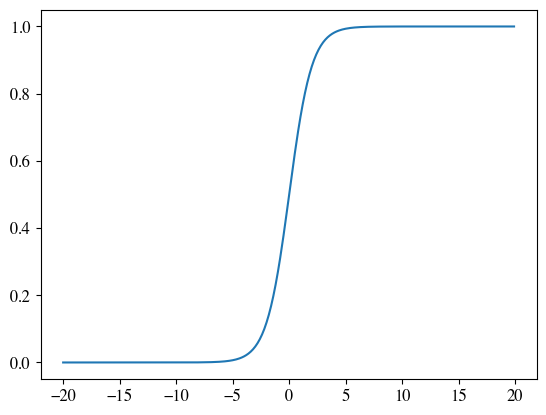
"/>

# Likelihood with negative sampling
<div align='center'><img src="figs/word2vec_negative_onesample.png" width='45%' ></div>
<br>
$$ \max_{\params} \underbrace{p(y=+1|w_{t-1},w_t;\params)}_{\text{pos. center vs context}}\cdot \underbrace{\prod_{k=1}^K p(y=0|w_k,w_t;\params)}_{\text{neg. center vs k samples}}$$

# Likelihood with negative sampling

$$ \max_{\params} \underbrace{p(y=+1|w_{t-1},w_t;\params)}_{\text{pos. center vs context}}\cdot \underbrace{\prod_{k=1}^K p(y=0|w_k,w_t;\params)}_{\text{neg. center vs k samples}}$$

We can apply $\log$ since is strictly monotonic, will not change the the optimization:

$$ \max_{\params} \log p(y=+1|w_{t-1},w_t;\params)+ \log \sum_{k=1}^K p(y=0|w_k,w_t;\params)$$

$$ \max_{\params} \log p(y=+1|w_{t-1},w_t;\params)+ \log \sum_{k=1}^K \underbrace{1- p(y=+1|w_k,w_t;\params)}_{\text{it is a binary classifier!}}$$

# Likelihood with negative sampling

$$ \max_{\params} \log p(y=+1|w_{t-1},w_t;\params)+  \sum_{k=1}^K \log\big[1- p(y=+1|w_k,w_t;\params)\big]$$

We replace $p(\cdot)$ with the logistic regression and using $\sigma(-z)= 1-\sigma(z)$, we get:

$$ \max_{\params} \log \sigma \left(\params_{C}[gt]^T\params_W[i]\right)+ \sum_{k=1}^K \log \big[ \sigma\left(-\params_{C}[k]^T\params_W[i]\right)\big]$$

# Loss with negative sampling

If we minimize, we have to invert the sign:

$$ \min_{\params} -\log \sigma \left(\params_{C}[gt]^T\params_W[i]\right) - \sum_{k=1}^K \log \big[ \sigma\left(-\params_{C}[k]^T\params_W[i]\right)\big]$$

# Visualization


<div align='center'><img src="figs/negative_params.png" width='65%' ></div>

# How to sample the negatives

Which is, how to select the indexes $k \in \{1\ldots K\}, k \neq gt$ in $\sum_{k=1}^K \log \big[ \sigma\left(-\params_{C}[k]^T\params_W[i]\right)\big]$ ?

We sample from an **Unigram model** defined over the corpus $V$ as:

$$ P(v)_{\alpha} = \frac{\operatorname{count(v)^\alpha}}{\sum_{v^{\prime}}\operatorname{count(v^{\prime})^\alpha}}$$
and fixing $\alpha=\frac{3}{4}=0.75$

<br>
Setting $\alpha=0.75$ gives better performance because <b>gives rare noise words slightly
higher probability</b>for rare words, $P(v)_{\alpha} > P(v)$ while <b>common words are more or less kept the same.</b>

# How to sample negative

$$ P(v)_{\alpha} = \frac{\operatorname{count(v)^\alpha}}{\sum_{v^{\prime}}\operatorname{count(v^{\prime})^\alpha}}$$
and fixing $\alpha=\frac{3}{4}=0.75$
<br><br>
**Example:**
$$\text{is:} \quad {0.9}^{.75} = 0.92\\
\text{Constitution:} \quad {0.09}^{.75} = 0.16\\
\text{bombastic:} \quad 0.01^{.75} = 0.032$$

# Sparse Gradients

- We iteratively take gradients at each window for SGD
- In each window, we only have at most $2m + 1$ words plus $2km$ negative words with negative sampling, so the gradient over a window $\nabla_{\params}\mathcal{L}_t({\params})$ is very sparse!
- Computationally, it is important to not have to send gigantic updates around.

$$
\nabla_\theta \mathcal{L}(\theta)=\left[\begin{array}{l}
\mbf{0} \\
\vdots \\
\nabla_{\params_W{_{l i k e}}} \\
\vdots \\
\mbf{0} \\
\nabla_{\params_W{_{am}}} \\
\vdots \\
\nabla_{\params_W{_{learning}}} \\
\vdots
\end{array}\right] \in \mathbb{R}^{2 d V}
$$

# Scaling word2vec with Hierarchical Softmax

# Hierarchical Softmax in NLP

It is an alternative to **Negative Sampling.** We do not use a contrastive method yet we approximate the normalization over the large vocabulary with a **balanced binary tree structure**.

Computational cost reduces from $\mathcal{O} \big( |V| \big)$ to $\mathcal{O}\big(\log_2(|V|)\big)$ **in the best case.**


# Regular Softmax is a degenerate tree!

We change point of view: softmax is a tree of depth=1 and $|V|$ children that are leaf too!

Corpus `this is an example of a huffman tree` and assume <ins>**word tokens are characters** to simplify.</ins>
<br><br>
<div align='center'><img src="figs/softmax_tree_linear.png" width='45%' ></div>


# Hierarchical Softmax in NLP

1. Given a vocabulary of word token $V$ how to construct the tree (there are multiple ways of doing it)
2. How to train with the tree
3. How to perform inference

# Huffman tree

Given a vocabulary of word token $V$ how to construct the tree? We use **Huffman trees**

The corpus is `this is an example of a huffman tree` and assume <ins>**word tokens are characters** to simplify.</ins>

| **chars** | **e** | **a** | **n** | **t** | **m** | **o** | **u** | **i** | **h** | **s** | **x** | **p** | **' '** | **f** | **r** | **l** |
|-----------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|---------|-------|-------|-------|
| **freq**  | 4     | 4     | 2     | 2     | 2     | 1     | 1     | 2     | 2     | 2     | 1     | 1     | 7       | 3     | 1     | 1     |

<div align='center'><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/82/Huffman_tree_2.svg/938px-Huffman_tree_2.svg.png" width='35%' ></div>

<small>picture from Wikipedia</small>

# Huffman tree

- vocabulary $V \rightarrow$ word frequencies with **Unigram model.**
- More frequent word tokens are placed closer to the root; rare words are at deeper layers.
    - If you think Information Theory, we "spend" less in encoding frequent words and each word has a variable code length.
    - We want to encode `'e'` with a bit string. Convention: left is `0` and right is `1`
    -  Then encoding of `'e'` is `left->left->left` which is `000` 3 bits
    - Yet the encoding of `'p'` is `right->left->left->right->right` which is `10011` 5 bits
- Each node has always two children

# Huffman tree

| **chars** | **e** | **a** | **n** | **t** | **m** | **o** | **u** | **i** | **h** | **s** | **x** | **p** | **' '** | **f** | **r** | **l** |
|-----------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|---------|-------|-------|-------|
| **freq**  | 4     | 4     | 2     | 2     | 2     | 1     | 1     | 2     | 2     | 2     | 1     | 1     | 7       | 3     | 1     | 1     |

<br><br>
<div align='center'><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/82/Huffman_tree_2.svg/938px-Huffman_tree_2.svg.png" width='55%' ></div>

<small>picture from Wikipedia</small>

# Training with Hierarchical Softmax

We do not model anymore $\params$ as the number of words in $V$, yet we model $\params$ as the number of internal nodes in the tree $V-1$.

We have a feature vector to be learned at each node $i$ of the tree for a total of $2V-1$ vectors to be learned (context and center).

Assume Skip-gram and we want to compute $p(w_{t-1}|w_t = \text{natural})$ and we assume the ground-truth $w_{t-1}$ is language.

<div align='center'><img src="figs/hsoftmax_1.png" width='35%' ></div>


# Training with Hierarchical Softmax

Assume Skip-gram and we want to compute $p(w_{t-1}|w_t = \text{natural})$ and we assume the ground-truth $w_{t-1}$ is language. 

So we "bypass" all path excepts the one that from root leads to `language`.

<div align='center'><img src="figs/hsoftmax_2.png" width='35%' ></div>


# Training with Hierarchical Softmax

$p(w_{t-1}|w_t = \text{natural})$ and we assume the ground-truth $w_{t-1}$ is language. 

$$p(w_{t-1}|w_t = \text{natural}) = \prod_{n~\in~path(\text{root}\rightarrow \text{language})} p_{\operatorname{branch}}\big(n,i\big)$$

where: 
$$ 
p_{\operatorname{branch}}(n,i) = \begin{cases} \sigma\big(\boldsymbol{\theta}_C[n]^T\boldsymbol{\theta}_W[i])\big), & \mbox{if } \mbox{left} \\ 
1-\sigma\big(\boldsymbol{\theta}_C[n]^T\boldsymbol{\theta}_W[i])\big), & \mbox{if } \mbox{right} \end{cases} 
$$
<br>
<div align='center'><img src="figs/hsoftmax_3.png?2" width='45%' ></div>

# Exercise: compute the loss with Hierarchical Softmax

$p(w_{t-1}|w_t = \text{natural})$ and we assume the ground-truth $w_{t-1}$ is language. 

<div align='center'><img src="figs/hsoftmax_3a.png?2" width='45%' ></div>

# Exercise: compute the loss with Hierarchical Softmax
<br>
<div align='center'><img src="figs/hsoftmax_3b.png?2" width='75%' ></div>

# Embeddings as a Matrix

The embedding $\params_C$ are still in a matrix, where each row of the matrix is indexed by the node $n$ index.

<div align='center'><img src="figs/hsoftmax_matrix.png?2" width='45%' ></div>

# Exercise: compute the loss with Hierarchical Softmax

$p(w_{t-1}|w_t = \text{natural})$ and we assume the ground-truth $w_{t-1}$ is language. 

<div align='center'><img src="figs/hsoftmax_3b.png?2" width='45%' ></div>

# Exercise: compute the loss with Hierarchical Softmax

$p(w_{t-1}|w_t = \text{natural})$ and we assume the ground-truth $w_{t-1}$ is language. 

<div align='center'><img src="figs/hsoftmax_3c.png?2" width='45%' ></div>

# Exercise: compute the loss with Hierarchical Softmax

$p(w_{t-1}|w_t = \text{natural})$ and we assume the ground-truth $w_{t-1}$ is language. 

<div align='center'><img src="figs/hsoftmax_3d.png?2" width='45%' ></div>

# Exercise: compute the loss with Hierarchical Softmax

$p(w_{t-1}|w_t = \text{natural})$ and we assume the ground-truth $w_{t-1}$ is language. 

<div align='center'><img src="figs/hsoftmax_3e.png?2" width='45%' ></div>

# Exercise: compute the loss with Hierarchical Softmax

$p(w_{t-1}|w_t = \text{natural})$ and we assume the ground-truth $w_{t-1}$ is language. 

<div align='center'><img src="figs/hsoftmax_3f.png?2" width='45%' ></div>

# Exercise: compute the loss with Hierarchical Softmax

$p(w_{t-1}|w_t = \text{natural})$ and we assume the ground-truth $w_{t-1}$ is language. 

<div align='center'><img src="figs/hsoftmax_3g.png?2" width='45%' ></div>

# Exercise: compute the loss with Hierarchical Softmax

$p(w_{t-1}|w_t = \text{natural}) = 1 \cdot 0.9\cdot0.95\cdot0.65\cdot0.2 = 0.11115$

Loss is $-\log\big(p(w_{t-1}|w_t = \text{natural})\big) = -\log(0.11115)$

<div align='center'><img src="figs/hsoftmax_3g.png?2" width='45%' ></div>

# Inference with Hierarchical Softmax

**Important:** In inference with do not have the label!

1. Exhaustive search [too complex]
2. Greedy search (at each branch take the branch at maximum probability) [too greedy]
3. **Beam search** (we will cover later on)



# Google Allo project used Hierarchical Softmax
Google (now dead) project Allo used a Hierarchical to speed up inference.
<br>
<div align='center'><img src="figs/allo_2016.png" width='35%' ></div>

<small>Taken from https://ai.googleblog.com/2016/05/chat-smarter-with-allo.html</small>

# Google Allo project used Hierarchical Softmax

Google (now dead ☠️ ) project Allo used a Hierarchical tree to speed up inference.
<br>
<div align='center'><img src="figs/allo_2016_beam_search.png" width='45%' ></div>

<small>Taken from https://ai.googleblog.com/2016/05/chat-smarter-with-allo.html</small>

# Google Allo project used Hierarchical Softmax

> As with any large-scale product, there were several engineering challenges we had to solve in generating a set of high-quality responses efficiently. For example, in spite of the two staged architecture, our first few networks were very slow and required about half a second to generate a response. This was obviously a deal breaker when we are talking about real time communication apps! 

> So we had to evolve our neural network architecture further to reduce the latency to less than 200ms. We moved from using **a softmax layer to a hierarchical softmax layer which traverses a tree of words instead of traversing a list of words thus making it more efficient.**

<small>Taken from https://ai.googleblog.com/2016/05/chat-smarter-with-allo.html</small>

# Evaluating Word Embeddings

Related to general evaluation in NLP/Machine Learning: **Intrinsic vs. Extrinsic**

- **Intrinsic**:
	- Evaluation on a specific/intermediate subtask
	- Fast to compute
	- Helps to understand that system
	- Not clear if really helpful unless correlation to real task is established
    - Often involve **correlation with human judgments**


- **Extrinsic**:
	- Evaluation on a real downstream task
	- Can take a long time to compute accuracy
	- Unclear if the subsystem is the problem or its interaction or other subsystems
	- If replacing exactly one subsystem with another improves accuracy $\rightarrow$ Winner! **(Ablation study)**
	- Always perform validation of the hyper-parameter on a validation (or dev) set; when you are sure then test once.

<small>Taken from cs224n Stanford NLP with Deep learning</small>

# Embedding and Historical Semantics
<br>
<div align='center'><img src="figs/historical.png" width='65%' ></div>


# Bias and Embeddings ⚠️

In addition to their ability to learn word meaning from text, embeddings, alas, also **reproduce the implicit biases and stereotypes** that were **latent in the text**

Besides the notorious $$ \text{man} : \text{king} = \text{woman} : \text{queen}  $$

the same embeddings analogies also **exhibit gender bias**

$$ \text{man} : \text{computer programmer} = \text{woman} : \text{homemaker}  $$

$$ \text{father} : \text{doctor} = \text{mother} : \text{nurse}  $$

# Bias and Embeddings ⚠️

Bias in the embeddings can cause **allocational harm**

>when a system allocates resources (jobs or credit) unfairly to different groups. For example algorithms
that use embeddings as part of a search for hiring potential programmers or doctors
might thus incorrectly downweight documents with women's names

# Bias and Embeddings ⚠️

Bias in the embeddings can cause **representational harm** as in bias towards the ethnicity groups

> Using such methods, people
in the United States have been shown to associate African-American names with
unpleasant words (more than European-American names), male names more with
mathematics and female names with the arts, and old people’s names with unpleasant words

# Debiasing in NLP/Machine Learning is an Open-Problem

# Word Embedding: Topics we did NOT cover

- **Global Vector - GloVe** Model: taking the best of both word (SVD-based and iterative, word2vec based). Invented by Stanford.
- **[fastext](https://fasttext.cc/)**: extension of word2vec to deal with the **Out of Vocabulary (OOV) problem**
    - [Fastext demo with Gensim](https://radimrehurek.com/gensim/auto_examples/tutorials/run_fasttext.html#sphx-glr-auto-examples-tutorials-run-fasttext-py)